## Adjusting marginals while keeping covariance fixed

Testing theory.

In [4]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import simulate, simulate_or_load, make_key
from localization.utils import plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort, build_DRT, normal_adjust, uniform_adjust, no_adjust
from scipy.special import erf

gaussian_cdf = lambda x: 0.5 * (erf(x/np.sqrt(2)) + 1)

def Z(g):
    return jnp.sqrt( (2/jnp.pi) * jnp.arcsin( (2*g**2) / (1 + (2*g**2)) ) )

In [120]:
config = dict(
  # data config
  num_dimensions=40,
  xi=(3, 3),
  adjust=(-1, 1),
  key=jax.random.PRNGKey(0),
)

def plot_covariance(x, interval=(0.5, 0.55)):
  xmask = (interval[0] < x[:,20]) & (x[:,20] < interval[1])
  xfilt = x[xmask]
  print(xfilt.shape)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

  im = ax1.imshow(x.T @ x / len(x))# / (Z(config['gain']) ** 2))
  cbar = fig.colorbar(im)

  # xxfilt = xfilt.T @ xfilt / len(xfilt)
  mufilt = np.mean(xfilt, axis=0)
  # covfilt = xxfilt - np.outer(mufilt, mufilt)
  covfilt = np.cov(xfilt.T)
  im = ax2.imshow(covfilt)# / (Z(config['gain']) ** 2))
  cbar = fig.colorbar(im)

  return (fig, (ax1, ax2)), (mufilt, covfilt)

(3266, 40)
(3105, 40)
(2783, 40)
(2361, 40)


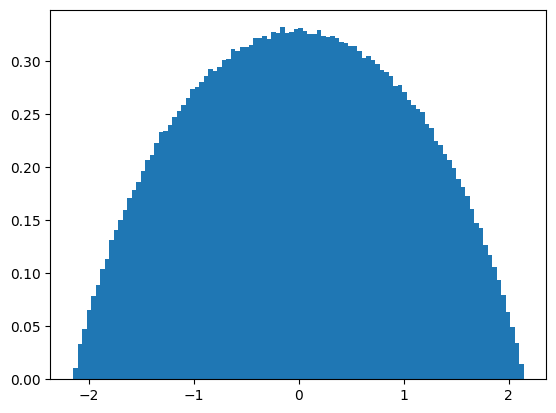

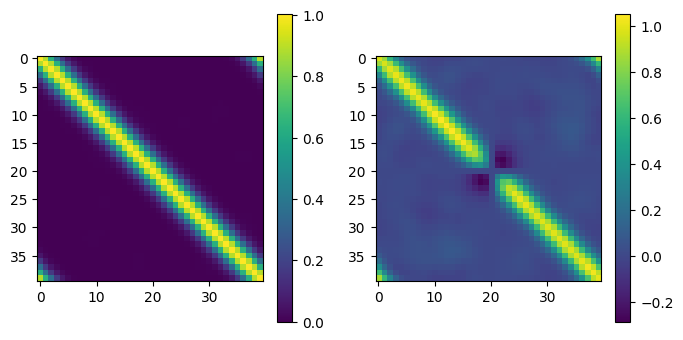

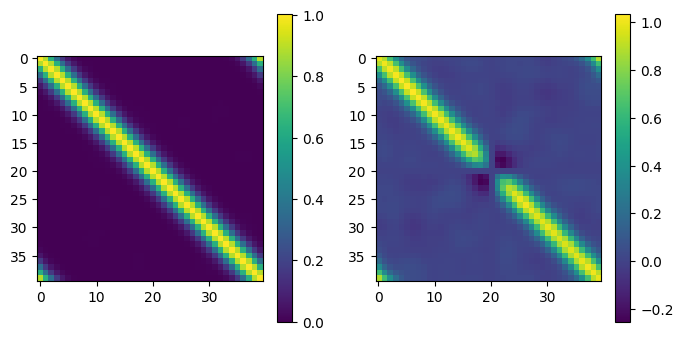

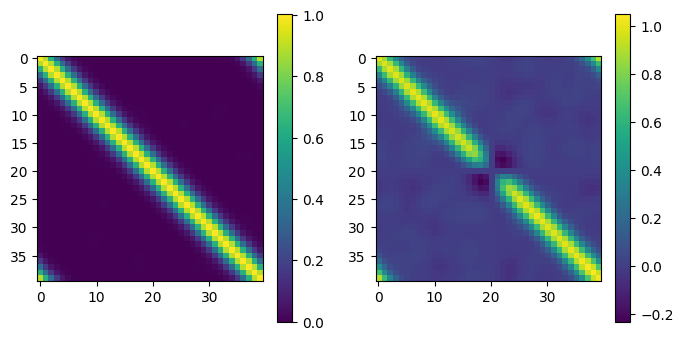

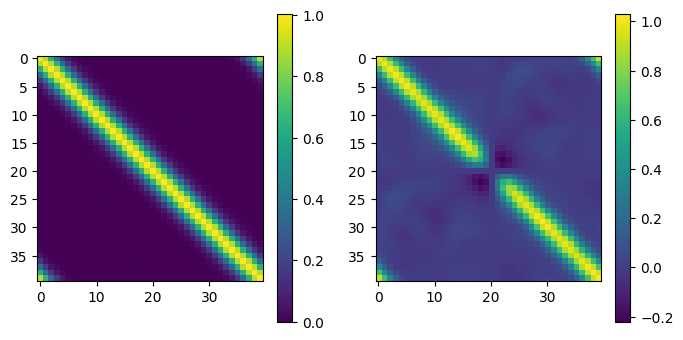

In [132]:
dataset = datasets.NonlinearGPDataset(gain=0.5, **config)
x = dataset[:1000000][0]
fig, ax = plt.subplots(1, 1); ax.hist(x[:,20], bins=100, density=True)#; ax.set_yscale('log'); ax.set_ylim(1e-5, 1e-1)
(fig, axs), (mu1, cov1) = plot_covariance(x, interval=(0.09, 0.1))
(fig, axs), (mu2, cov2) = plot_covariance(x, interval=(0.59, 0.6))
(fig, axs), (mu3, cov3) = plot_covariance(x, interval=(0.99, 1.0))
(fig, axs), (mu4, cov4) = plot_covariance(x, interval=(1.26, 1.27))

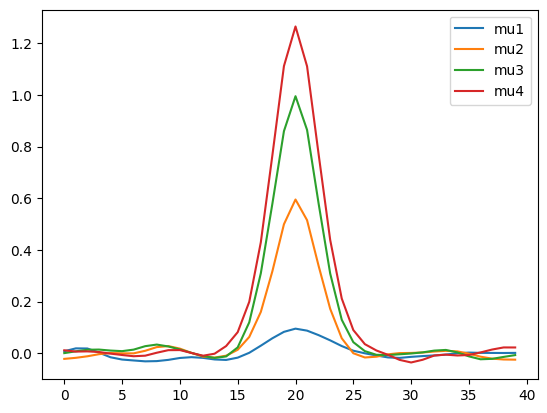

In [133]:
_ = plt.plot(mu1, label='mu1')
_ = plt.plot(mu2, label='mu2')
_ = plt.plot(mu3, label='mu3')
_ = plt.plot(mu4, label='mu4')
_ = plt.legend()

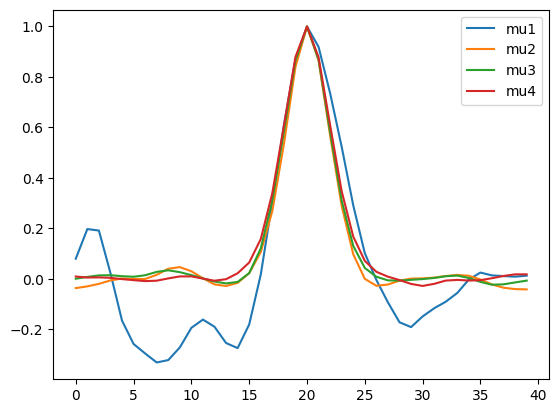

In [134]:
_ = plt.plot(mu1 / mu1.max(), label='mu1')
_ = plt.plot(mu2 / mu2.max(), label='mu2')
_ = plt.plot(mu3 / mu3.max(), label='mu3')
_ = plt.plot(mu4 / mu4.max(), label='mu4')
_ = plt.legend()

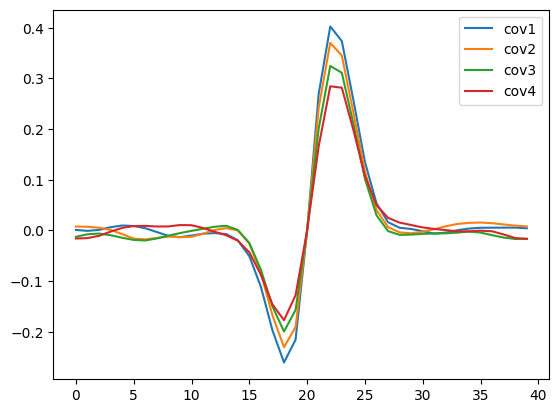

In [142]:
i = 21
_ = plt.plot(cov1[:,i], label='cov1')
_ = plt.plot(cov2[:,i], label='cov2')
_ = plt.plot(cov3[:,i], label='cov3')
_ = plt.plot(cov4[:,i], label='cov4')
_ = plt.legend()

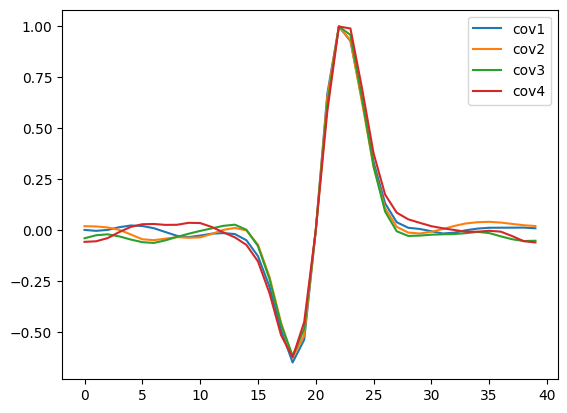

In [140]:
i = 21
_ = plt.plot(cov1[:,i] / cov1[:,i].max(), label='cov1')
_ = plt.plot(cov2[:,i] / cov2[:,i].max(), label='cov2')
_ = plt.plot(cov3[:,i] / cov3[:,i].max(), label='cov3')
_ = plt.plot(cov4[:,i] / cov4[:,i].max(), label='cov4')
_ = plt.legend()

In [181]:
def cov_max_vs_interval(x, intervals: list[tuple]):
    covs = np.zeros((len(intervals), x.shape[1], x.shape[1]))
    n = np.zeros(len(intervals))
    for i, interval in enumerate(intervals):
        xmask = (interval[0] < x[:,20]) & (x[:,20] < interval[1])
        xfilt = x[xmask]
        covfilt = np.cov(xfilt.T)
        covs[i] = covfilt
        n[i] = len(xfilt)
    return covs, covs[:,:,21].max(axis=1), n


marginals = np.linspace(0.01, 1.5, 50)
intervals = [(m - 0.005, m + 0.005) for m in marginals]

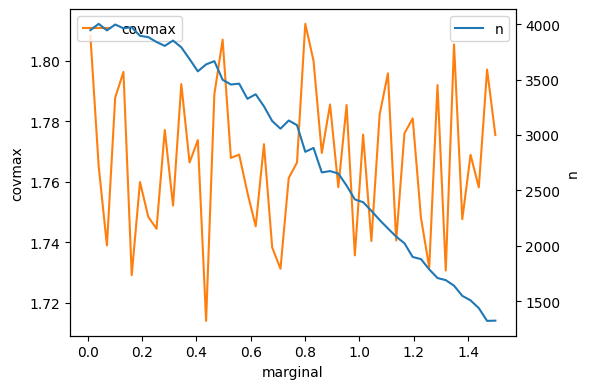

In [182]:
dataset = datasets.NonlinearGPDataset(gain=0.01, **config)
x = dataset[:1000000][0]
covs, covmaxes, n = cov_max_vs_interval(x, intervals=intervals)
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
# ax0.hist(x[:,20], bins=100, density=True)
ax1.plot(marginals, 1 / np.sqrt(covmaxes), label='covmax', color='tab:orange'); ax1.set_xlabel('marginal'); ax1.set_ylabel('covmax')
ax2 = ax1.twinx(); ax2.plot(marginals, n, label='n', color='tab:blue'); ax2.set_xlabel('marginal'); ax2.set_ylabel('n')
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
fig.tight_layout()

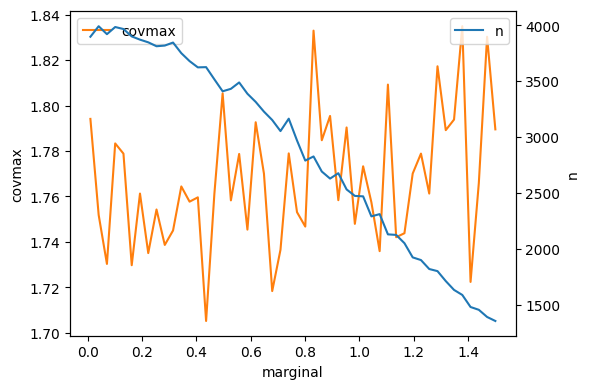

In [183]:
dataset = datasets.NonlinearGPDataset(gain=0.1, **config)
x = dataset[:1000000][0]
covs, covmaxes, n = cov_max_vs_interval(x, intervals=intervals)
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
# ax0.hist(x[:,20], bins=100, density=True)
ax1.plot(marginals, 1 / np.sqrt(covmaxes), label='covmax', color='tab:orange'); ax1.set_xlabel('marginal'); ax1.set_ylabel('covmax')
ax2 = ax1.twinx(); ax2.plot(marginals, n, label='n', color='tab:blue'); ax2.set_xlabel('marginal'); ax2.set_ylabel('n')
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
fig.tight_layout()

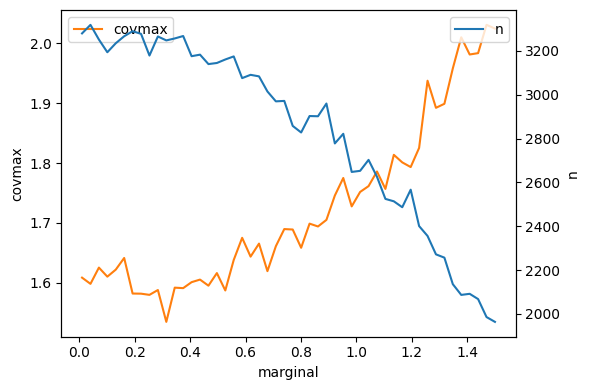

In [184]:
dataset = datasets.NonlinearGPDataset(gain=0.5, **config)
x = dataset[:1000000][0]
covs, covmaxes, n = cov_max_vs_interval(x, intervals=intervals)
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
# ax0.hist(x[:,20], bins=100, density=True)
ax1.plot(marginals, 1 / np.sqrt(covmaxes), label='covmax', color='tab:orange'); ax1.set_xlabel('marginal'); ax1.set_ylabel('covmax')
ax2 = ax1.twinx(); ax2.plot(marginals, n, label='n', color='tab:blue'); ax2.set_xlabel('marginal'); ax2.set_ylabel('n')
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
fig.tight_layout()

/var/folders/gq/3xlhh9496_j9xpjb7tkbqh280000gn/T/ipykernel_66391/654291642.py:7: RuntimeWarning: Degrees of freedom <= 0 for slice
  covfilt = np.cov(xfilt.T)


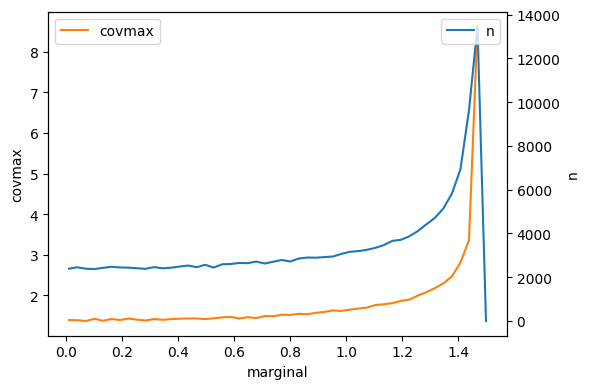

In [185]:
dataset = datasets.NonlinearGPDataset(gain=1, **config)
x = dataset[:1000000][0]
covs, covmaxes, n = cov_max_vs_interval(x, intervals=intervals)
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
# ax0.hist(x[:,20], bins=100, density=True)
ax1.plot(marginals, 1 / np.sqrt(covmaxes), label='covmax', color='tab:orange'); ax1.set_xlabel('marginal'); ax1.set_ylabel('covmax')
ax2 = ax1.twinx(); ax2.plot(marginals, n, label='n', color='tab:blue'); ax2.set_xlabel('marginal'); ax2.set_ylabel('n')
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
fig.tight_layout()

/var/folders/gq/3xlhh9496_j9xpjb7tkbqh280000gn/T/ipykernel_66391/654291642.py:7: RuntimeWarning: Degrees of freedom <= 0 for slice
  covfilt = np.cov(xfilt.T)


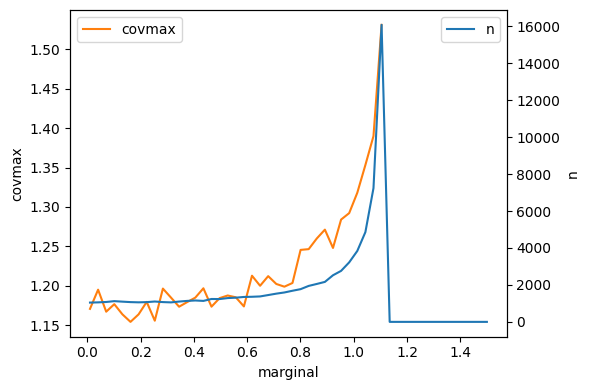

In [186]:
dataset = datasets.NonlinearGPDataset(gain=3, **config)
x = dataset[:1000000][0]
covs, covmaxes, n = cov_max_vs_interval(x, intervals=intervals)
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
# ax0.hist(x[:,20], bins=100, density=True)
ax1.plot(marginals, 1 / np.sqrt(covmaxes), label='covmax', color='tab:orange'); ax1.set_xlabel('marginal'); ax1.set_ylabel('covmax')
ax2 = ax1.twinx(); ax2.plot(marginals, n, label='n', color='tab:blue'); ax2.set_xlabel('marginal'); ax2.set_ylabel('n')
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
fig.tight_layout()

/var/folders/gq/3xlhh9496_j9xpjb7tkbqh280000gn/T/ipykernel_66391/654291642.py:7: RuntimeWarning: Degrees of freedom <= 0 for slice
  covfilt = np.cov(xfilt.T)


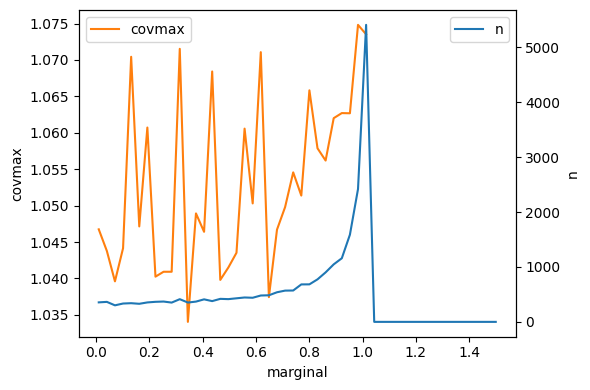

In [187]:
dataset = datasets.NonlinearGPDataset(gain=10, **config)
x = dataset[:1000000][0]
covs, covmaxes, n = cov_max_vs_interval(x, intervals=intervals)
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
# ax0.hist(x[:,20], bins=100, density=True)
ax1.plot(marginals, 1 / np.sqrt(covmaxes), label='covmax', color='tab:orange'); ax1.set_xlabel('marginal'); ax1.set_ylabel('covmax')
ax2 = ax1.twinx(); ax2.plot(marginals, n, label='n', color='tab:blue'); ax2.set_xlabel('marginal'); ax2.set_ylabel('n')
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
fig.tight_layout()

In [ ]:
dataset = datasets.NonlinearGPDataset(gain=0.5, **config)
x = dataset[:1000000][0]
fig, ax = plt.subplots(1, 1); ax.hist(x[:,20], bins=100, density=True)#; ax.set_yscale('log'); ax.set_ylim(1e-5, 1e-1)
(fig, axs), (mu1, cov1) = plot_covariance(x, interval=(0.09, 0.1))
(fig, axs), (mu2, cov2) = plot_covariance(x, interval=(0.59, 0.6))
(fig, axs), (mu3, cov3) = plot_covariance(x, interval=(0.99, 1.0))
(fig, axs), (mu4, cov4) = plot_covariance(x, interval=(1.26, 1.27))

(673, 40)


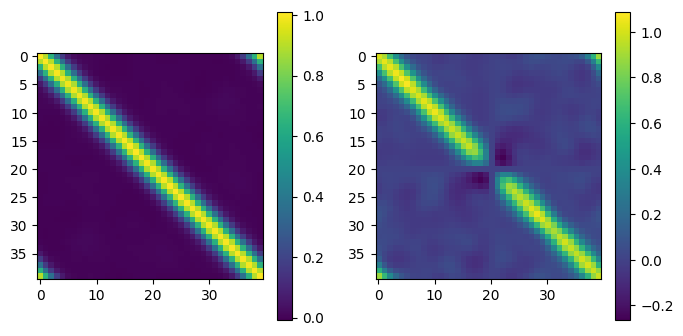

In [32]:
interval = (0.97, 1.0)
(fig, axs), (mu1, cov1) = plot_covariance(0.01, interval=interval)

(698, 40)


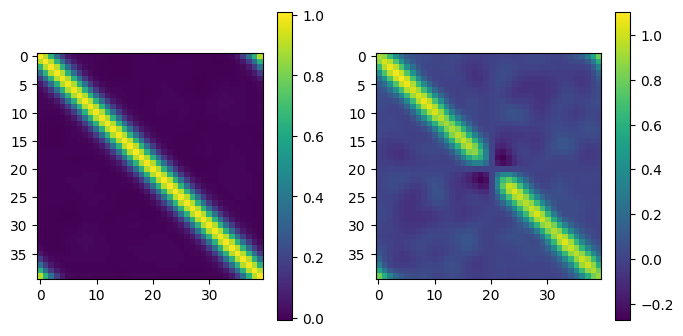

In [33]:
(fig, axs), (mu2, cov2) = plot_covariance(0.1, interval=interval)

(904, 40)


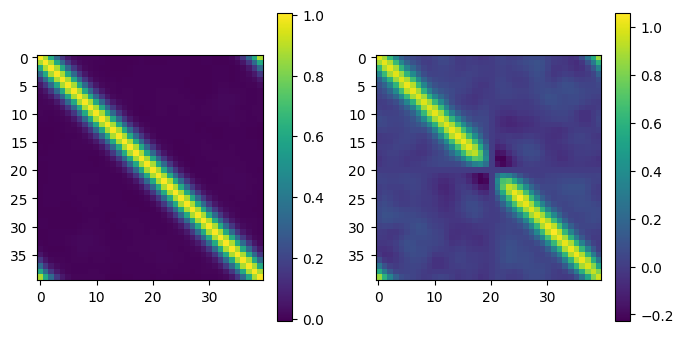

In [34]:
(fig, axs), (mu3, cov3) = plot_covariance(1, interval=interval)

(737, 40)


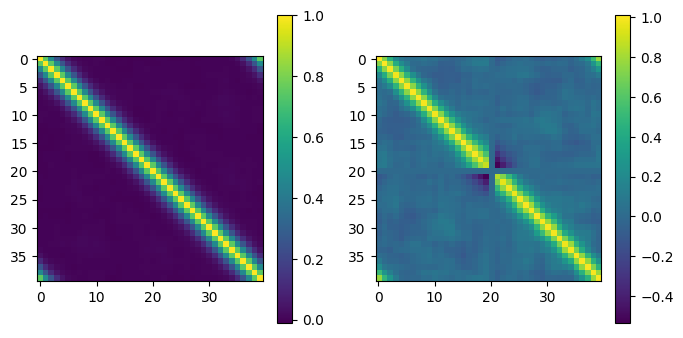

In [35]:
(fig, axs), (mu4, cov4) = plot_covariance(10, interval=interval)

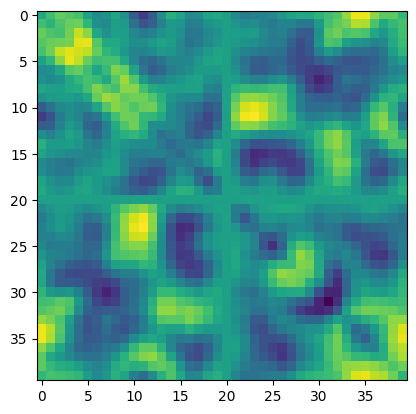

In [38]:
_ = plt.imshow(cov1 - cov3)